In [20]:
import datetime
today = datetime.date.today()
datestr = today.strftime('%m-%d 00:00 현재')
print(f'데이터 분석시점: {datestr}')

데이터 분석시점: 03-07 00:00 현재


# 코로나바이러스감염증-19 감염현황 데이터 일일 분석

질병관리본부에서 매일 발표하고 있는 일일 집계 현황을 다음의 구글 시트에 별도로 저장한 후, 이를 분석합니다.

https://docs.google.com/spreadsheets/d/1nqc9A9M5QJgSnjkErWeyDS4KTiLB1N9VjHd3T6k69hE/

활용 가능한 데이터가 추가되는대로 계속 보완합니다. 

In [14]:
%matplotlib inline

from io import BytesIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import requests

matplotlib 차트 한글폰트 설정

In [15]:
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

구글시트에 정리된 데이터를 가져옵니다.

In [16]:
r = requests.get('https://docs.google.com/spreadsheet/ccc?key=1nqc9A9M5QJgSnjkErWeyDS4KTiLB1N9VjHd3T6k69hE&output=csv')
df = pd.read_csv(BytesIO(r.content), index_col=0, skiprows=1).iloc[2:, :-4]
df.columns = [c.replace('\n', ' ') for c in df.columns]
df.index = pd.to_datetime([f'2020-{i}' for i in df.index])
df['대구'] = df['대구'].str.replace(',', '').astype(float)
df['경북'] = df['경북'].str.replace(',', '').astype(float)
df['확진자'] = df['확진자'].str.replace(',', '').astype(float)
df['검사수'] = df['검사수'].str.replace(',', '').astype(float)
df = df.replace(np.nan, 0).sort_index()

In [17]:
df.head()

,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,...,전남,경북,경남,제주,지역 모름,확진자,사망,격리 해제,검사수,양성 비율(%)
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,22.0,4.55
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,25.0,4.00
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,48.0,2.08
2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,57.0,1.75


누적값을 별도 컬럼에 추가합니다.

In [18]:
for c in df.columns:
    df[f'{c} 누적'] = df[c].cumsum()

df.head()

,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,...,전남 누적,경북 누적,경남 누적,제주 누적,지역 모름 누적,확진자 누적,사망 누적,격리 해제 누적,검사수 누적,양성 비율(%) 누적
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,22.0,4.55
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,47.0,8.55
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,47.0,8.55
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,95.0,10.63
2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,152.0,12.38


누적 양성비율, 누적 사망율, 누적 대구경북 비율, 누적 완치율을 계산합니다. 확산 시작 직전으로 보이는 2월 15일 부터 표시합니다.

In [19]:
df['누적 양성비율'] = 100 * df['확진자 누적'] / df['검사수 누적']
df['누적 사망율'] = 100 * df['사망 누적'] / df['확진자 누적']
df['누적 대구경북'] = 100 * (df['대구 누적'] + df['경북 누적']) / df['확진자 누적']
df['누적 완치율'] = 100 * df['격리  해제 누적'] / df['확진자 누적']
df = df.loc['2020-02-15':]

일일 현황을 차트로 표시합니다.

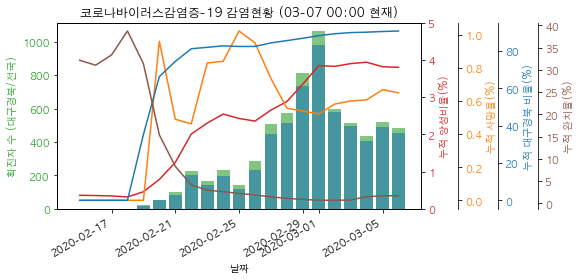

In [22]:
fig, ax1 = plt.subplots(figsize=(8, 4))

color = 'tab:green'
ax1.set_xlabel('날짜')
ax1.set_ylabel('확진자 수 (대구경북/전국)', color=color)
#ax1.set_ylim(0, 1000)
plt.bar(x=df.index, height=df['확진자'], color=color, alpha=0.6)
plt.bar(x=df.index, height=df['대구']+df['경북'], color="tab:blue", alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('누적 양성비율(%)', color=color)  # we already handled the x-label with ax1
ax2.plot(df['누적 양성비율'], color=color)
ax2.set_ylim(0., 5.)
ax2.tick_params(axis='y', labelcolor=color)

color = 'tab:orange'
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.10))
ax3.set_ylabel('누적 사망율(%)', color=color)  # we already handled the x-label with ax1
ax3.plot(df['누적 사망율'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.21))
ax4.set_ylabel('누적 대구경북 비율(%)', color=color)  # we already handled the x-label with ax1
ax4.plot(df['누적 대구경북'], color=color)
ax4.tick_params(axis='y', labelcolor=color)

color = 'tab:brown'
ax5 = ax1.twinx()
ax5.spines["right"].set_position(("axes", 1.32))
ax5.set_ylabel('누적 완치율(%)', color=color)  # we already handled the x-label with ax1
ax5.plot(df['누적 완치율'], color=color)
ax5.tick_params(axis='y', labelcolor=color)

#plt.xticks(rotation=90)
fig.autofmt_xdate()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'코로나바이러스감염증-19 감염현황 ({datestr})')

fig.tight_layout()
plt.show()

여러 차트를 종합하여 한장의 그림을 만듭니다. 가능한 한장의 차트에 모든 정보를 담을 수 있도록 노력합니다.

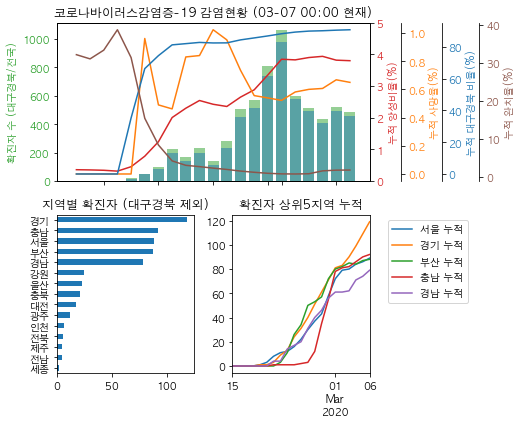

In [24]:
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(2, 1, 1)
color = 'tab:green'
ax1.set_xlabel('날짜')
ax1.set_ylabel('확진자 수 (대구경북/전국)', color=color)
plt.bar(x=df.index, height=df['확진자'], color=color, alpha=0.5)
plt.bar(x=df.index, height=df['대구']+df['경북'], color="tab:blue", alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title(f'코로나바이러스감염증-19 감염현황 ({datestr})')
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
plt.setp(ax1.get_xticklabels(), visible=True)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('누적 양성비율(%)', color=color)  # we already handled the x-label with ax1
ax2.plot(df['누적 양성비율'], color=color)
ax2.set_ylim(0., 5.)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
color = 'tab:orange'
ax3.spines["right"].set_position(("axes", 1.10))
ax3.set_ylabel('누적 사망율(%)', color=color)  # we already handled the x-label with ax1
ax3.plot(df['누적 사망율'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax1.twinx()
color = 'tab:blue'
ax4.spines["right"].set_position(("axes", 1.23))
ax4.set_ylabel('누적 대구경북 비율(%)', color=color)  # we already handled the x-label with ax1
ax4.plot(df['누적 대구경북'], color=color)
ax4.tick_params(axis='y', labelcolor=color)

ax5 = ax1.twinx()
color = 'tab:brown'
ax5.spines["right"].set_position(("axes", 1.35))
ax5.set_ylabel('누적 완치율(%)', color=color)  # we already handled the x-label with ax1
ax5.plot(df['누적 완치율'], color=color)
ax5.tick_params(axis='y', labelcolor=color)

axb = fig.add_subplot(2,2,3)
axb.set_title('지역별 확진자 (대구경북 제외)')
wotk = list(df.columns[:17])
wotk.remove('대구')
wotk.remove('경북')
df[wotk].sum().sort_values().plot(kind='barh', ax=axb)

axb2 = fig.add_subplot(2,2,4)
axb2.set_title('확진자 상위5지역 누적')
df[['서울 누적', '경기 누적', '부산 누적', '충남 누적', '경남 누적']].plot(ax=axb2)
axb2.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
axb2.xaxis.set_minor_locator(mdates.MonthLocator())

fig.tight_layout()
#fig.autofmt_xdate()
plt.savefig(f'covid19-stat-{today.strftime("%m%d")}.png', dpi=200, format='png')